# Load the necessary packages

In [1]:
#Neural Networks
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from skimage import io, transform

#Matplotlib
import matplotlib.pyplot as plt
import numpy as np

#For image processing and the Dataset class
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from PIL import Image

#CSV and File management
import os
import pandas as pd

#Display matplotlib within jupyter notebook
plt.ion()

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:232: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [5]:
data_folder = os.path.join(os.getcwd(), "data")

train_df = pd.read_csv(os.path.join(data_folder, "Train.csv"))
test_df  = pd.read_csv(os.path.join(data_folder, "Test.csv" ))

# The following cell plots all Pokemon of a given Pokedex number, specified from a csv dataframe

Note: it also returns a dataframe of the specified pokemon and their labels + dexnum

[32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


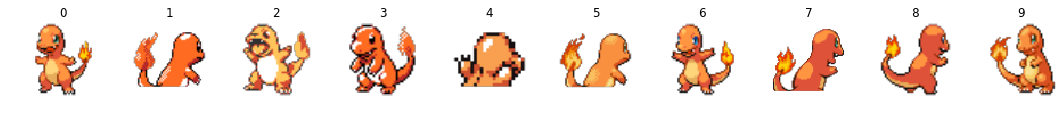

                                              pokemon dex_number normal  \
32  /home/ubuntu/PokemonTypeNN/data/dpp/charmander...          4      0   
33  /home/ubuntu/PokemonTypeNN/data/gsc-back/charm...          4      0   
34  /home/ubuntu/PokemonTypeNN/data/rby/charmander...          4      0   
35  /home/ubuntu/PokemonTypeNN/data/gsc/charmander...          4      0   
36  /home/ubuntu/PokemonTypeNN/data/rby-back/charm...          4      0   
37  /home/ubuntu/PokemonTypeNN/data/rse-back/charm...          4      0   
38  /home/ubuntu/PokemonTypeNN/data/bw/charmander.png          4      0   
39  /home/ubuntu/PokemonTypeNN/data/dpp-back/charm...          4      0   
40  /home/ubuntu/PokemonTypeNN/data/bw-back/charma...          4      0   
41  /home/ubuntu/PokemonTypeNN/data/rse/charmander...          4      0   

   fighting flying poison ground rock bug ghost steel fire water grass  \
32        0      0      0      0    0   0     0     0    1     0     0   
33        0      0      0 

In [6]:
def plot_all(dex_num, df):

    df_idxs = [i for i in range(0,len(df)) if df["dex_number"].iloc[i] == dex_num]
    print(df_idxs)
    fig = plt.figure(figsize=(15,15))
    labels = pd.DataFrame(columns=list(df))
    
    for i in range(0, len(df_idxs)):
        
        ax = plt.subplot(1, len(df_idxs), i+1)
        plt.tight_layout()
        ax.set_title(i)
        ax.axis("off")
        pkm_image = io.imread(df["pokemon"].iloc[ df_idxs[i] ])
        plt.imshow(pkm_image)
        print(np.array(pkm_image).shape)
        labels = labels.append(df.iloc[ df_idxs[i]])

    plt.show()
    return labels

#plot an example
temp_labels = plot_all(4,train_df)
print(temp_labels)

# Create the PokemonDataset (loads the project's Train/Test.csv formats)

inspiration: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [16]:
#TODO: Figure out how matrices are fed into pytorch

class PokemonDataset(Dataset):
    """Pokemon Dataset. """
    
    def __init__(self, csv_file_loc, transform=None):
        """
        Args:
            csv_file_loc (string): Path to the csv file
            transform (callable, optional): Optional transform to be applied to the sample
        
        """
        self.df = pd.read_csv(csv_file_loc)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name = self.df["pokemon"].iloc[index]
        
        #Read the Image
        image = io.imread(img_name)
        if self.transform:
            image  = self.transform(image )
            
        #Read the labels
        labels = self.df.iloc[index, 2:].values
        labels = labels.astype("float").reshape(len(labels))
        
        #Concat the images and labels as a "Sample" dictionary
        sample = {"image": image, "labels": labels}
        return sample, index
    
    def getpokemon(self, index):
        return self.df["pokemon"].iloc[index]

# Create Transformation Classes

In [5]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    
    def __call__(self, sample):
        image, labels = sample["image"], sample["labels"]
        
        #swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        
        image = image.transpose((2, 0, 1))
        return {"image": torch.from_numpy(image),
                "labels": torch.from_numpy(labels)}

# Load the Pokemon Datasets for the Neural Network

In [17]:
#random vertical flip?

theTransformations = transforms.Compose([transforms.ToPILImage(),
                                         transforms.RandomAffine(degrees=40, translate=(0.2, 0.2), 
                                                                 shear =0.2, scale=(1, 1.3),
                                                                 fillcolor=(255,255,255)),
                                         transforms.RandomHorizontalFlip(p=0.5),
                                         transforms.ToTensor()])

#Trainset uses theTransformations; Test set only uses ToTensor
trainset = PokemonDataset(csv_file_loc = os.path.join(data_folder, "Train.csv"),
                         transform = theTransformations)
testset  = PokemonDataset(csv_file_loc = os.path.join(data_folder, "Test.csv" ),
                         transform = transforms.Compose([transforms.ToTensor()]))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                         shuffle=True,  num_workers=2)
testloader  = torch.utils.data.DataLoader(testset , batch_size=16,
                                         shuffle=False, num_workers=2)

classes = list(train_df)[2:]
print(classes)

['normal', 'fighting', 'flying', 'poison', 'ground', 'rock', 'bug', 'ghost', 'steel', 'fire', 'water', 'grass', 'electric', 'psychic', 'ice', 'dragon', 'dark', 'fairy']


# Test with some Training Images

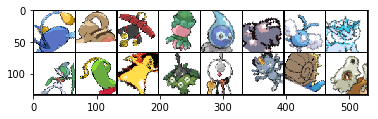

In [18]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

#get some random training images
dataiter = iter(trainloader)
minibatch, index = dataiter.next()
images, labels = minibatch["image"], minibatch["labels"]

#show images
imshow(torchvision.utils.make_grid(images))


# Define a Convolutional Neural Network!

In [19]:
#Print if cuda is available
print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)


True
cuda:0


In [12]:
# # 
# # check for multi-classification: https: //stackoverflow.com/questions/52855843/multi-label-classification-in-pytorch
# # check for explanation of NN parameters: https://www.aiworkbox.com/lessons/how-to-define-a-convolutional-layer-in-pytorch
# # check for reference model: https://nextjournal.com/gkoehler/pytorch-mnist
# # loss function: BCELoss
# # use sigmoid for multiple classes?

# # Use THIS PAGE to calculate matrix outputs: https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d

# # goal: convolve -> ReLu -> pool -> convolve -> ReLu -> pool -> Linear -> ReLu -> Linear -> ReLu -> Linear -> Sigmoid
# # Loss function: BCELoss

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
        
#         #in_channels = number of colors (3), out_channels are the desired number to be learned, and 
#         #kernel_size says whether to use nearby pixels  
        
#         #TODO: remove stride in CNN (stride only later)
#         # probably don't need so many linear layers
#         # Add regularization
#         # Do random shuffle to prpove that the network works
        
        
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size = 5, stride=2) # 6 output
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.conv2 = nn.Conv2d(in_channels=6, out_channels=18, kernel_size = 5, stride=2) #12 output
#         self.fc1 = nn.Linear(in_features = 162, out_features= 120) #in_features=108
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 18)
        
        
#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(x.shape[0], -1)
#         #print(x.shape)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.sigmoid(self.fc3(x))
#         return x
    
# net = Net()
# #net.cuda()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 18, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=162, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=18, bias=True)
)

In [42]:
# 
# check for multi-classification: https: //stackoverflow.com/questions/52855843/multi-label-classification-in-pytorch
# check for explanation of NN parameters: https://www.aiworkbox.com/lessons/how-to-define-a-convolutional-layer-in-pytorch
# check for reference model: https://nextjournal.com/gkoehler/pytorch-mnist
# loss function: BCELoss
# use sigmoid for multiple classes?

# Use THIS PAGE to calculate matrix outputs: https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d

# goal: convolve -> ReLu -> pool -> convolve -> ReLu -> pool -> Linear -> ReLu -> Linear -> ReLu -> Linear -> Sigmoid
# Loss function: BCELoss

class Net(nn.Module):
        
    def __init__(self, name="noNameProvided"):
        super(Net, self).__init__()
        #in_channels = number of colors (3), out_channels are the desired number to be learned, and 
        #kernel_size says whether to use nearby pixels  
        
        #TODO: remove stride in CNN (stride only later)
        # probably don't need so many linear layers
        # Add regularization
        # Do random shuffle to prpove that the network works
        
        self.setName(name)
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size = 5, stride=1) # 6 output
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=18, kernel_size = 5, stride=1) #12 output
        self.conv3 = nn.Conv2d(in_channels=18, out_channels=32, kernel_size = 5, stride=1)
        self.fc1 = nn.Linear(in_features = 512, out_features= 120) #in_features=108
        self.fc2 = nn.Linear(in_features = 120, out_features = 84)
        self.fc3 = nn.Linear(in_features = 84, out_features=18)
        
    def setName(self,name):
        self.name = name
        
    def getName(self):
        return self.name
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.shape[0], -1)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x
    
net = Net("3Con3FC")

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 18, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(18, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=18, bias=True)
)

# Define a loss function and an optimizer

In [43]:
import torch.optim as optim

loss_fn = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001) #0.001

use_cuda = True

# Train the Network

In [44]:
max_epochs = 100

epochs_to_print = 200

if use_cuda:
    net.cuda()

for epoch in range(max_epochs):
    
    running_loss = 0.0
    
    for i, (minibatch, index) in enumerate(trainloader):
        #get the inputs
        images, labels = minibatch["image"], minibatch["labels"]
        if use_cuda:
            images = images.float().cuda()
            labels = labels.float().cuda()
        else:
            images = images.float()
            labels = labels.float()
        
        
        #zero the parameter gradients
        optimizer.zero_grad()
        
        #forward + backward + optimize
        outputs = net(images) #net.forward()
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print statistics
        running_loss += loss.item()
        if i % epochs_to_print == epochs_to_print-1: #print every epochs_to_print mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / epochs_to_print))
            running_loss = 0.0

### 
# Save the Model
###
saveloc = os.path.join(os.getcwd(), "model")
print("*************************************************************************")
if(not os.path.exists(saveloc)):
    try:
        os.mkdir(saveloc)
    except OSError:
        print("Creation of the directory %s failed" %saveloc)
    else:
        print("Successfully created the directory %s" %saveloc)
print("*************************************************************************")
torch.save(net, os.path.join(saveloc,net.getName()+".pt"))
print("Finished training")

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,   200] loss: 0.300
[2,   200] loss: 0.276
[3,   200] loss: 0.275
[4,   200] loss: 0.270
[5,   200] loss: 0.269
[6,   200] loss: 0.266
[7,   200] loss: 0.266
[8,   200] loss: 0.264
[9,   200] loss: 0.263
[10,   200] loss: 0.261
[11,   200] loss: 0.261
[12,   200] loss: 0.260
[13,   200] loss: 0.259
[14,   200] loss: 0.257
[15,   200] loss: 0.258
[16,   200] loss: 0.258
[17,   200] loss: 0.256
[18,   200] loss: 0.255
[19,   200] loss: 0.255
[20,   200] loss: 0.256
[21,   200] loss: 0.254
[22,   200] loss: 0.252
[23,   200] loss: 0.250
[24,   200] loss: 0.249
[25,   200] loss: 0.247
[26,   200] loss: 0.245
[27,   200] loss: 0.241
[28,   200] loss: 0.242
[29,   200] loss: 0.239
[30,   200] loss: 0.240
[31,   200] loss: 0.235
[32,   200] loss: 0.237
[33,   200] loss: 0.233
[34,   200] loss: 0.233
[35,   200] loss: 0.233
[36,   200] loss: 0.233
[37,   200] loss: 0.230
[38,   200] loss: 0.229
[39,   200] loss: 0.227
[40,   200] loss: 0.227
[41,   200] loss: 0.225
[42,   200] loss: 0.222
[

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Test that the Model was Saved

In [45]:
#Test that the model was saved:

model = torch.load(os.path.join(saveloc, net.getName()+".pt"))
model.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 18, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(18, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=18, bias=True)
)

# Test the Network

In [49]:
#Specify the loader
somevar = "test"

if(somevar == "train"):
    loader = trainloader
    theset = trainset
elif(somevar == "test"):
    loader = testloader
    theset = testset
else:
    raise ValueError("Please specify what to test on!")

In [56]:
true_pos  = np.zeros(len(classes)) #array of number of times a class was successfully predicted
false_pos = np.zeros(len(classes)) #array of number of times a class was guessed when it should NOT have been guessed
false_neg = np.zeros(len(classes)) #array of number of times a class was not guessed when it should have been guessed
actual_dist = np.zeros(len(classes)) #array of actual number of classes present in the test set

correct_pokemon = [] #list of Pokemon that were perfectly predicted 
pokemon_guesses = {} #dictionary of Pokemon and the NN's type guess
threshold = 0.5

if use_cuda:
    #bring back to CPU so that we can do train/test evaluation
    net.cpu()

with torch.no_grad():
    for i, (minibatch, index) in enumerate(loader):
        images, labels = minibatch["image"], minibatch["labels"]
        images = images.float()
        labels = labels.float()
        outputs = net(images)
        
        for j in range(images.shape[0]):
            
            #see which indices are above our threshold
            poss_indices = outputs[j] >= threshold
            
            #we haven't identified a type! pick the largest type as the prediction
            if(sum(poss_indices) < 1):
                big_class_index = np.argmax(outputs[j].numpy())
                outputs[j] = torch.zeros(outputs[j].shape, dtype=torch.uint8)
                outputs[j][big_class_index] = 1
                
            #there are too many types identified! Pick the largest two
            elif(sum(poss_indices) > 2):
                temp_outputs = outputs[j].numpy()
                big_class_index = np.argsort(temp_outputs)[-2:]
                outputs[j] = torch.zeros(outputs[j].shape, dtype=torch.uint8)
                outputs[j][big_class_index] = 1
                
            #only 1 or 2 classes beat the threshold! Set only those to 1; everything else to 0
            else:
                outputs[j] = torch.zeros(outputs[j].shape, dtype=torch.uint8)
                outputs[j][poss_indices] = 1
            
            #create a dictionary of Pokemon and the NN's prediction of its typing
            predicted_type = [classes[c] for c in range(len(classes)) if outputs[j][c] == 1]
            pokemon_guesses[theset.getpokemon(index.numpy()[j])] = predicted_type
            #print(theset.getpokemon(index.numpy()[j]), "\'s type :: ", predicted_type)
            
            
            #Gather NN stats
            numpy_labels  = labels[j].numpy()
            numpy_outputs = outputs[j].numpy()
            
            #number of Pokemon perfectly guessed by NN
            if(np.array_equal(numpy_labels, numpy_outputs)):
                correct_pokemon.append(theset.getpokemon(index.numpy()[j]))
            
            #number of classes present in the test set
            actual_dist[numpy_labels == 1] += 1
            
            #counts the number of correctly identified classes
            #also counts the number of guessed classes by the NN
            for t in range(len(classes)):
                if numpy_labels[t] ==1 and numpy_outputs[t] == 1:
                    true_pos[t] += 1
                    
                if numpy_labels[t] == 1 and numpy_outputs[t] == 0:
                    false_pos[t] += 1
                
                if numpy_labels[t] == 0 and numpy_outputs[t] == 1:
                    false_neg[t] += 1
            
            
       # _, predicted = torch.max(outputs, 1)

         # following code is onlyl for single image identification
#         for j in range(images.shape[0]):
#             print(testset.getpokemon(index.numpy()[j])," \'s type:: ", classes[predicted[j]])
#             if(labels.numpy()[j][predicted[j]] == 1):
#                 class_correct[predicted[j]] = class_correct[predicted[j]]+1
#                 correct_pokemon.append(testset.getpokemon(index.numpy()[j]))
    
precision = (true_pos) / ( (true_pos) + (false_pos))
precision = np.round(precision, decimals=2)
recall    = (true_pos) / ( (true_pos) + (false_neg))
recall    = np.round(recall, decimals=2)
F1 = 2 * precision * recall/ (precision + recall)
F1 = np.round(F1, decimals=2)

nprec = len(classes)
nrec = len(classes)
nf1 = len(classes)

mean_Precision = 0
mean_Recall = 0
mean_F1 = 0

for t in range(0, len(classes)):
    if(not np.isnan(precision[t])):
        mean_Precision += precision[t]
    else:
        nprec -= 1
    
    if(not np.isnan(recall[t])):
        mean_Recall += recall[t]
    else:
        nrec -= 1
        
    if(not np.isnan(F1[t])):
        mean_F1 += F1[t]
    else:
        nf1 -= 1
        
mean_Precision /= nprec
mean_Recall    /= nrec
mean_F1        /= nf1

print("True Pos :: ", true_pos)
print("False Neg :: ", false_neg)
print("False Pos :: ", false_pos)
print("****************************************")
print("Correctly identified class percentage (True Pos):: ", true_pos/actual_dist)
print("Recall (average) :: ", mean_Recall)
print("Precision (average) :: ", mean_Precision)
print("F1 Score (average) :: ", mean_F1)
print("Correctly identified Pokemon percentage :: ", len(correct_pokemon)/theset.__len__())
print("Perfectly identified Pokemon :: ")
for pkm in correct_pokemon:
    print(pkm, " :: ", pokemon_guesses[pkm])
#print("Random Guess accuracy :: ", (1/18))


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


True Pos ::  [23.  1.  9.  3.  2.  2.  4.  1.  4. 15. 26. 27.  9.  3.  1.  0.  3.  0.]
False Neg ::  [26.  7. 28. 16. 14. 11.  8.  5.  2. 12. 37. 25.  6. 18.  1.  2.  6.  6.]
False Pos ::  [27. 33. 33. 11. 22. 18. 40. 17. 28. 17. 12. 25. 15. 29. 17. 24. 29.  6.]
****************************************
Correctly identified class percentage (True Pos)::  [0.46       0.02941176 0.21428571 0.21428571 0.08333333 0.1
 0.09090909 0.05555556 0.125      0.46875    0.68421053 0.51923077
 0.375      0.09375    0.05555556 0.         0.09375    0.        ]
Recall (average) ::  0.30499999999999994
Precision (average) ::  0.20277777777777775
F1 Score (average) ::  0.245625
Correctly identified Pokemon percentage ::  0.16193181818181818
Perfectly identified Pokemon :: 
/home/ubuntu/PokemonTypeNN/data/bw/snivy.png  ::  ['grass']
/home/ubuntu/PokemonTypeNN/data/bw/servine.png  ::  ['grass']
/home/ubuntu/PokemonTypeNN/data/bw-back/servine.png  ::  ['grass']
/home/ubuntu/PokemonTypeNN/data/bw/serperior.p

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in true_divide


# Print Precision, Recall, and F1 in Table Format

In [57]:
rows = np.row_stack((precision, recall, F1))
results_df = pd.DataFrame(rows, columns=classes)
results_df.insert(loc=0, column="Results", value=["Precision", "Recall", "F1"])

print(results_df)

# print(classes)
# print("Actual classes :: ")
# print(actual_class)
# print("***********")
# print("Guessed classes :: ")
# print(guessed_classes)

     Results  normal  fighting  flying  poison  ground  rock   bug  ghost  \
0  Precision    0.46      0.03    0.21    0.21    0.08  0.10  0.09   0.06   
1     Recall    0.47      0.12    0.24    0.16    0.12  0.15  0.33   0.17   
2         F1    0.46      0.05    0.22    0.18    0.10  0.12  0.14   0.09   

   steel  fire  water  grass  electric  psychic   ice  dragon  dark  fairy  
0   0.12  0.47   0.68   0.52      0.38     0.09  0.06     0.0  0.09    0.0  
1   0.67  0.56   0.41   0.52      0.60     0.14  0.50     0.0  0.33    0.0  
2   0.20  0.51   0.51   0.52      0.47     0.11  0.11     NaN  0.14    NaN  


In [43]:
for key in pokemon_guesses:
    print(key, " :: ", pokemon_guesses[key])

/home/tariq/PokemonTypeNN/data/bw/victini.png  ::  ['fire']
/home/tariq/PokemonTypeNN/data/bw-back/victini.png  ::  ['flying']
/home/tariq/PokemonTypeNN/data/bw/snivy.png  ::  ['fighting']
/home/tariq/PokemonTypeNN/data/bw-back/snivy.png  ::  ['flying', 'grass']
/home/tariq/PokemonTypeNN/data/bw/servine.png  ::  ['flying', 'bug']
/home/tariq/PokemonTypeNN/data/bw-back/servine.png  ::  ['flying']
/home/tariq/PokemonTypeNN/data/bw/serperior.png  ::  ['fighting', 'grass']
/home/tariq/PokemonTypeNN/data/bw-back/serperior.png  ::  ['grass', 'psychic']
/home/tariq/PokemonTypeNN/data/bw/tepig.png  ::  ['flying', 'ghost']
/home/tariq/PokemonTypeNN/data/bw-back/tepig.png  ::  ['grass']
/home/tariq/PokemonTypeNN/data/bw/pignite.png  ::  ['flying', 'fire']
/home/tariq/PokemonTypeNN/data/bw-back/pignite.png  ::  ['water']
/home/tariq/PokemonTypeNN/data/bw/emboar.png  ::  ['normal']
/home/tariq/PokemonTypeNN/data/bw-back/emboar.png  ::  ['flying', 'fairy']
/home/tariq/PokemonTypeNN/data/bw/oshawott

In [32]:
# Test the train/test loader

for i in range(len(trainset)):
    sample = trainset[i]
    
    print(i, sample["image"].size(), sample["labels"].size())
    
    if(i == 3):
        break


0 torch.Size([3, 64, 64]) torch.Size([1, 18])
1 torch.Size([3, 64, 64]) torch.Size([1, 18])
2 torch.Size([3, 64, 64]) torch.Size([1, 18])
3 torch.Size([3, 64, 64]) torch.Size([1, 18])


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [11]:
dic = {"a":[1,2,3,4],"b": "led", "c":10}
x, y, z = dic
print(x)

a


# Test the PokemonDataset

/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


0 (64, 64, 4) (1, 18)
[[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]
1 (64, 64, 4) (1, 18)
[[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]
2 (64, 64, 4) (1, 18)
[[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]
3 (64, 64, 4) (1, 18)
[[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]


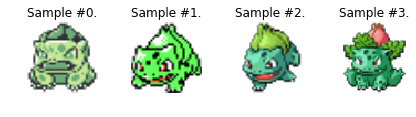

In [71]:
fig = plt.figure()

for i in range(len(trainset)):
    sample = trainset[i]
    
    print(i, sample["image"].shape, sample["labels"].shape)
    
    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title("Sample #{}.".format(i))
    ax.axis("off")
    plt.imshow(sample["image"])
    print(sample["labels"])
    
    if i == 3:
        plt.show()
        break